In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import OperatorTools as OT
import GridTransferTools as GTT
import TestTools as TT
import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 1000)

In [2]:
nh = 64
refRatio = 2
finehalf = list(np.arange(int(nh / refRatio)))
omega = BT.Grid(nh)
omegaFine = omega
wavesFine = WT.MakeWaves(omega)
omega.AddCell(refRatio, finehalf)
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
wavesMod = waves @ nullspace
sigma = 0.1
mu = 0.5
c = 1.
nt = 160
CFL = 0.5

[64, 128]
look: 128 128
h is 0.015625
[ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]
[ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126]
64 128
[[ 6.36619772e-01  6.47619126e-01  6.16584665e-01 ...  6.46335344e-01  1.58666421e-02  6.36619772e-01]
 [-6.36619772e-01  5.84064798e-01 -6.77093416e-01 ... -6.44778265e-01 -4.75617022e-02 -6.36619772e-01]
 [-6.36619772e-01 -7.04936529e-01 -5.50137867e-01 ...  6.41667860e-01  7.91421820e-02  6.36619772e-01]
 ...
 [-5.92561524e-15 -5.98106395e-01 -1.49817853e-01 ... -3.85527956e-03 -1.53911387e-02  0.00000000e+00]
 [ 3.74185090e-15  6.09911067e

(96, 96)
(96,)
(96,)
Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/MixedWave.


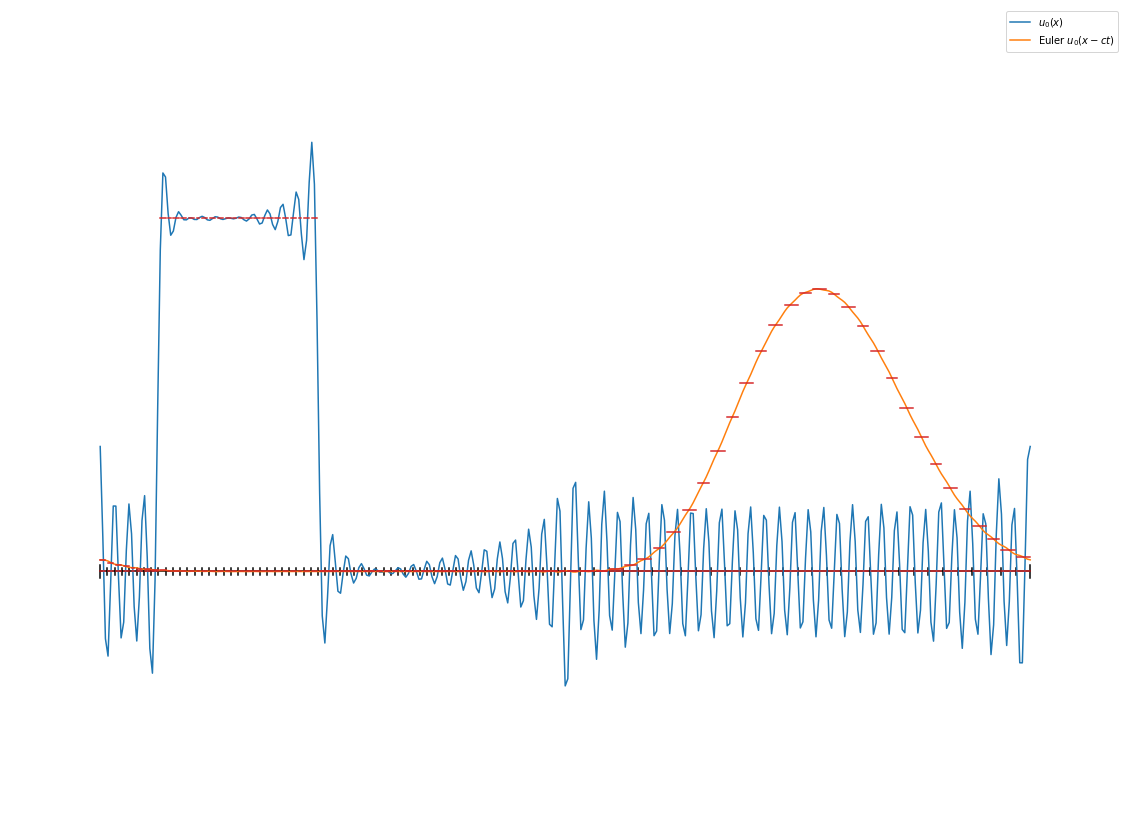

In [3]:
func = np.zeros(omega.degFreed, float) # TT.Gauss(omega, sigma, mu)
func[8:30] = 1
print(np.shape(wavesMod))
print(np.shape(func))
FCoefs = FFTT.FourierCoefs(omega, wavesMod, func)
# FCoefs[::2] = 0
gauss = wavesMod @ FCoefs
EulerCoefs, t = ST.ForwardEuler(omega, wavesMod, func, nt, c, CFL)
print(np.shape(EulerCoefs))
# propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
allCoefs = PT.Load(FCoefs, EulerCoefs)
PT.PlotMixedWave(omega, waves, nullspace @allCoefs, rescale = [4, 6], labels = [r'$u_{0} (x)$', r'Euler $u_{0} (x - c t)$'], save = True)



In [4]:
ks, error = TT.CalcError(omega, propFCoefs, EulerCoefs, errorType = 'relative')
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, error)
# plt.plot(ks, EulerCoefs)
# plt.plot(ks, propFCoefs)
plt.title('Error for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.show()

NameError: name 'propFCoefs' is not defined

In [5]:
norms, CFLs = TT.NormVersusCFL(ST.ForwardEuler, omega, waves, gauss, c, CFL, nt, normType = 'L1', errorType = 'absolute')
plt.figure()
plt.plot(CFLs, norms)
plt.title('Error versus CFL Condition for Forward Euler')
plt.xlabel('CFL')
plt.ylabel('Error')
plt.show()


LinAlgError: Last 2 dimensions of the array must be square

In [6]:
A = np.arange(20)
B = A[::2][1:]
C = A[1::2][:-1]
print(A)
print(B)
print(C)
print(propFCoefs)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 2  4  6  8 10 12 14 16 18]
[ 1  3  5  7  9 11 13 15 17]


NameError: name 'propFCoefs' is not defined

In [7]:
ampKs, ampError = TT.AmpError(omega, EulerCoefs, propFCoefs)

NameError: name 'propFCoefs' is not defined

In [8]:
ks, error = TT.CalcError(omega, propFCoefs, EulerCoefs, errorType = 'relative')
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, ampError)
plt.title('Amplitude Error for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.show()

NameError: name 'propFCoefs' is not defined

In [9]:
deltaCoefs = np.ones(nh, float)
PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 128)

In [10]:
deltaCoefs[1::2] = 0
PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 128)

In [11]:
deltaCoefs = np.ones(nh, float)
deltaCoefs[::2] = 0
PT.PlotMixedWave(omega, waves, deltaCoefs, rescale = [4, 6])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 128)

In [12]:
Cosine = lambda k: np.cos(2. * np.pi * k)
Sine = lambda k: np.sin(2. * np.pi * k)
RotMat = lambda k: np.asarray([Cosine(k), -Sine(k), Sine(k), Cosine(k)]).reshape(2, 2)
print(RotMat(0.125))

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [13]:
def ExplicitMidpoint(omega, waves, u0, nt, const, CFL, periodic = True):
    degFreed = omega.degFreed
    x = omega.xCell
    dx = omega.dx
    dx_0 = 1 - x[::-1][0] + x[0]
    dt = CFL * dx / const
    dt_0 = CFL * dx_0 / const
    t = nt * dt[0]
    u = u0.copy()
    
    
#     for n in range(nt):
#         u_f = u[::-1][0]
#         u[1:] = u[1:] - (const * (dt / dx) * (u[1:] - u[:-1]))
#         if (periodic == True):
#             u[0] = u[0] - (const * (dt_0 / dx_0) * (u[0] - u_f))
    
    h = (b - a) / n;
halfh = h / 2;
y(1,:) = ya;
t(1) = a;
for i = 1 : n
    t(i+1) = t(i) + h;
    z = y(i,:) + halfh * f(t(i),y(i,:));
    y(i+1,:) = y(i,:) + h * f(t(i)+halfh,z);
    
    
    uCoefs = LA.inv(waves) @ u
    return uCoefs, t

SyntaxError: invalid syntax (<ipython-input-13-1f928e602e30>, line 20)

In [42]:
def MidpointMeth(omega, waves, u0, nt, const, CFL, periodic = True): # (def_fn, a, b, N, ya):
    degFreed = omega.degFreed
    x = omega.xCell
    dx = omega.dx
    dx_min = np.min(dx)
    dx_0 = 1 - x[::-1][0] + x[0]
    dt = CFL * dx_min / const
    dt_0 = CFL * dx_0 / const
    t = nt * dt
    u = u0.copy()
    u1 = u0.copy()
    for n in range(nt):
        u1, t = ST.ForwardEuler(omega, waves, u1, 1, const, CFL / 2, periodic = periodic)
        u2, t = ST.ForwardEuler(omega, waves, u + (dt * u1 / 2.), 1, const, CFL / 2, periodic = periodic)
        u = u + (dt * u2)
    uCoefs = LA.inv(waves) @ u

    return uCoefs, t

In [43]:
nh = 64
refRatio = 2
omega = BT.Grid(nh)
waves = WT.MakeWaves(omega)
nt = 20

(96, 96)
(64,)
(64,)
Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/MixedWave.


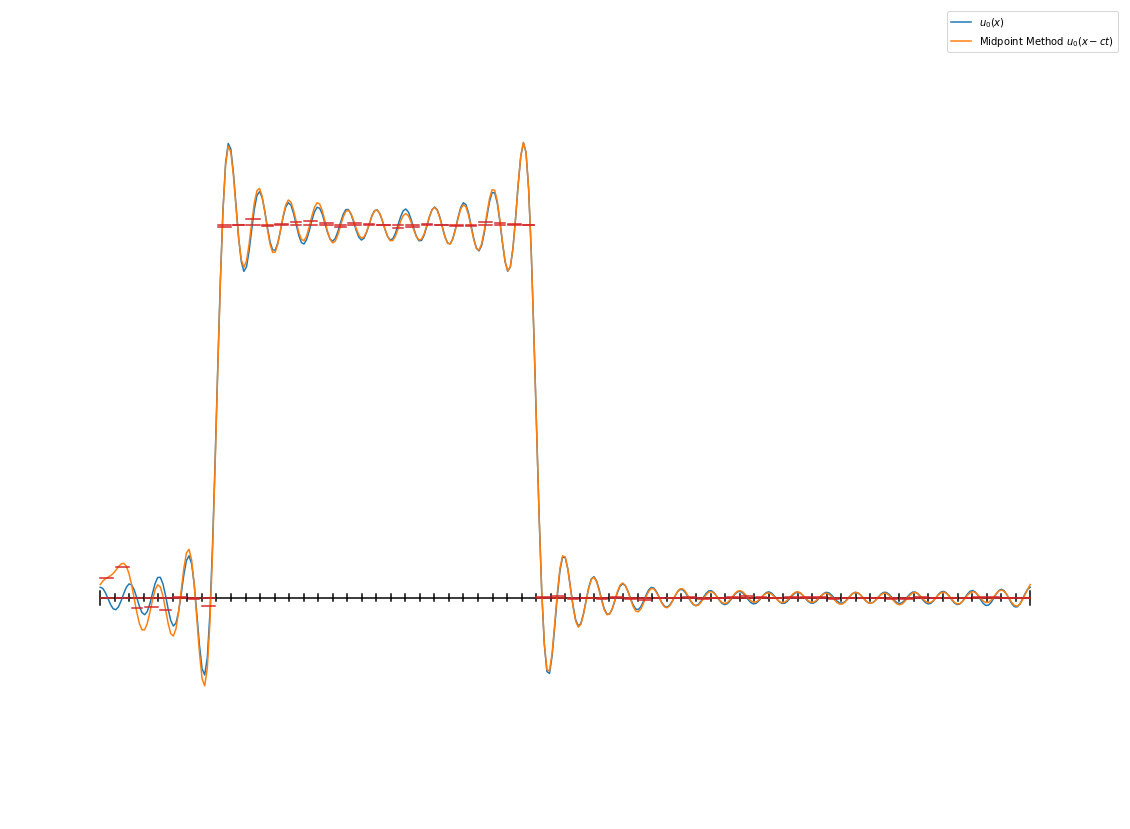

In [44]:
func = np.zeros(omega.degFreed, float) # TT.Gauss(omega, sigma, mu)
func[8:30] = 1
print(np.shape(wavesMod))
print(np.shape(func))
FCoefs = FFTT.FourierCoefs(omega, waves, func)
# FCoefs[::2] = 0
EulerCoefs, t = MidpointMeth(omega, waves, func, nt, c, CFL)
print(np.shape(EulerCoefs))
# propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
allCoefs = PT.Load(FCoefs, EulerCoefs)
PT.PlotMixedWave(omega, waves, allCoefs, rescale = [4, 6], labels = [r'$u_{0} (x)$', r'Midpoint Method $u_{0} (x - c t)$'], save = True)

